In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('/home/xilinx/jupyter_notebooks/qickdawg/src/')

import qickdawg as qd
from copy import copy
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

In [2]:
qd.start_client("172.16.26.5")

In [29]:
default_config = qd.NVConfiguration()

default_config.test = True
default_config.mw_readout_channel = 1
default_config.ddr4 = True
default_config.ddr4_channel = 0
default_config.n_ddr4_chunks = 5000

default_config.adc_channel = 0 

default_config.mw_channel = 1
default_config.mw_nqz = 1
default_config.mw_gain = 5000

default_config.laser_gate_pmod = 0

default_config.relax_delay_treg = 100 # between each rep, wait for everything to catch up, mostly aom


In [30]:
config = copy(default_config)

config.soft_avgs = 1
config.readout_integration_treg = 1020
prog = qd.LaserOn(config)
_ = prog.acquire_decimated(progress=False)
data = prog.acquire_decimated(progress=False)
on_value  = np.mean(data)
print('Approximate on intensity {} ADC units'.format(on_value))

prog = qd.LaserOff(config)
_ = prog.acquire_decimated(progress=False)
data = prog.acquire_decimated(progress=False)
off_value  = np.mean(data)
print('Approximate off intensity {} ADC units'.format(off_value))


Approximate on intensity 1961.2656862745098 ADC units
Approximate off intensity 1.4725490196078432 ADC units


In [51]:
for i in range(2):
    
    qd.soc.clear_ddr4()

    config = copy(default_config)
    
    config.mw_gain = 30000
    config.mw_fMHz = 2870
    config.mw_pi2_treg = 100
    
    config.pre_init = True

    config.relax_delay_treg = 100

    config.laser_on_treg = 5000 # in us
    config.readout_integration_treg = 700  # us
    config.readout_reference_start_treg = 3500 # us

    config.laser_readout_offset_treg = 135#
    config.mw_readout_delay_treg = 45

    config.add_linear_sweep('delay', 'treg', start=8, stop=800, delta=8)

    config.reps = 1

    config.ddr4_channel = i

    prog = qd.Ramsey(config)
    d = prog.acquire(raw_data=False, progress=True)

    if i == 0:
        laser_ddr4 = qd.soc.get_ddr4(config.n_ddr4_chunks)[:, 0]
    elif i == 1:
        mw_ddr4 = qd.soc.get_ddr4(config.n_ddr4_chunks)
        mw_real = mw_ddr4[:, 0]
        mw_imag = mw_ddr4[:, 1]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/amounce/python/qickdawg/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/amounce/python/qickdawg/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


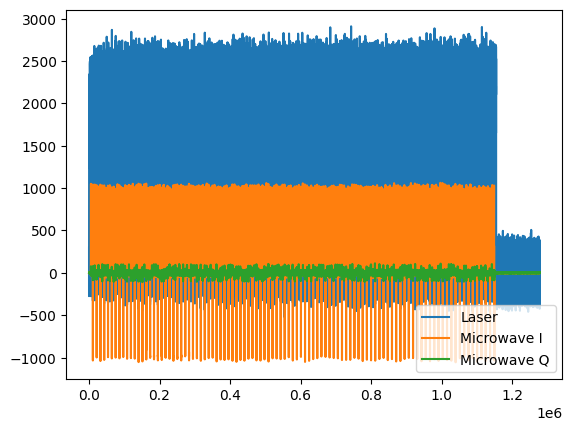

In [52]:
start = 5370
end = 5460

phase = np.arctan(np.mean(mw_real[start:end]) / np.mean(mw_imag[start:end]))
phase -= np.pi/2

x = mw_real * np.cos(phase) - mw_imag * np.sin(phase)
y = mw_real * np.sin(phase) + mw_imag * np.cos(phase)

plt.plot(laser_ddr4, label='Laser')
plt.plot(x, label='Microwave I')
plt.plot(y, label='Microwave Q')
plt.legend()

In [53]:
laser_start_treg = find_peaks(np.gradient(laser_ddr4), height=200)[0]
laser_end_treg = find_peaks(np.gradient(-laser_ddr4), height=200)[0]
mw_start_treg = find_peaks(np.gradient(np.abs(x)), height=150)[0]
mw_end_treg = find_peaks(np.gradient(-np.abs(x)), height=150)[0]

laser_norm = laser_ddr4 /np.max(laser_ddr4)
x_norm = x /np.max(x)

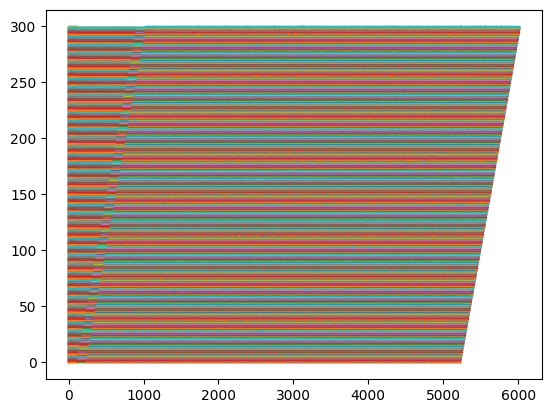

In [59]:
# plt.plot(laser_ddr4/np.max(laser_ddr4) + 1.5, label='Laser')
# plt.plot(x/np.max(x), label='Microwave I')
# # plt.plot(y, label='Microwave Q')
# plt.legend()
# plt.show()

for i in range((len(mw_start_treg)+1)//2):
    i_end = mw_end_treg[2 * i + 1] + config.laser_on_treg + 10

    plt.plot(x_norm[mw_start_treg[2 * i] - 10: i_end]  + i * 1.5)
    plt.plot(laser_norm[mw_start_treg[2 * i]- 10: i_end] + i * 1.5)


In [60]:
# should be equal to the mw pulse time in treg for pi/2, pi, pi/2

mw_end_treg - mw_start_treg

array([ 99, 100, 100,  99, 100, 100,  99, 100, 100, 100,  99,  99, 100,
       100,  99, 100, 100, 100, 100, 100,  99, 100, 100,  99, 100,  99,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100,  99, 100,  99, 100, 100, 100,  99, 100,  99, 100,
        99, 100, 100, 100,  99, 100,  99, 100,  99,  99, 100, 100, 100,
       100, 100, 100, 100, 100,  99, 100, 100,  99, 100,  99, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,  99,
       100, 100, 100,  99,  99, 100, 100,  99, 100, 100, 100,  99,  99,
       100, 100,  99, 100, 100, 100, 100, 100,  99, 100, 100,  99, 100,
       100, 100, 100, 100,  99, 100, 100, 100, 100,  99, 100,  99, 100,
       100,  99, 100,  99, 100,  99, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100,  99, 100, 100, 100, 100, 100, 100, 100, 100,  99,
       100,  99, 100,  99, 100, 100, 100, 100,  99, 100, 100, 100, 100,
        99, 100, 100, 100, 100, 100,  99, 100, 100, 100, 100, 10

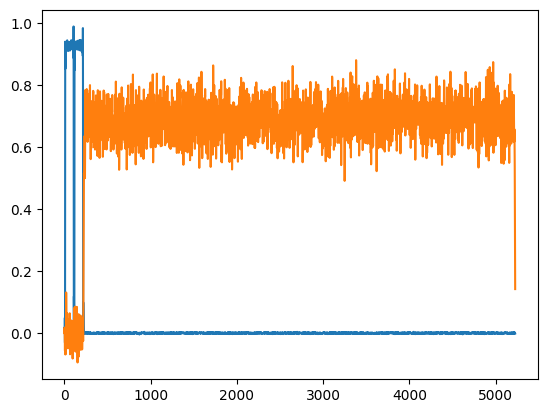

In [61]:
# should be equal to the readout window time in treg
i = 0
i_end = mw_end_treg[2 * i + 1] + config.laser_on_treg + 10

plt.plot(x_norm[mw_start_treg[2 * i] - 10: i_end]  + i * 1.5)
plt.plot(laser_norm[mw_start_treg[2 * i]- 10: i_end] + i * 1.5)


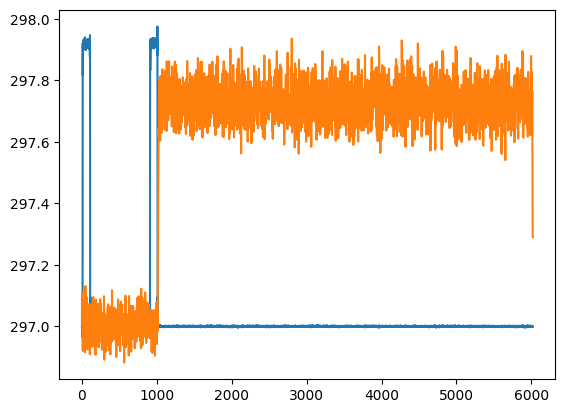

In [62]:
i = 198
i_end = mw_end_treg[2 * i + 1] + config.laser_on_treg + 10

plt.plot(x_norm[mw_start_treg[2 * i] - 10: i_end]  + i * 1.5)
plt.plot(laser_norm[mw_start_treg[2 * i]- 10: i_end] + i * 1.5)

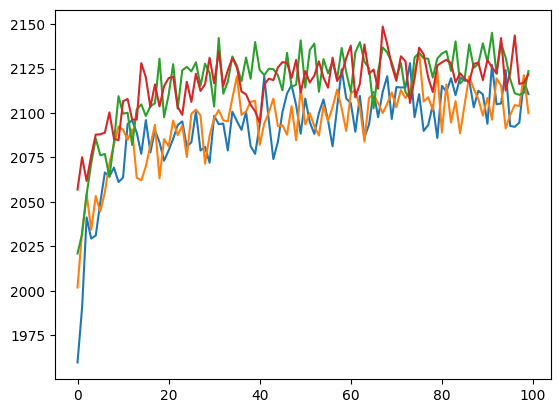

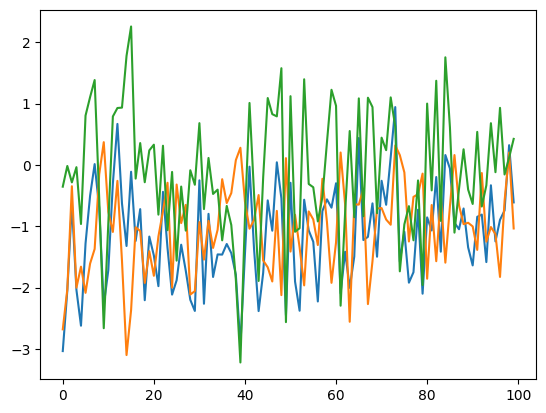

In [63]:
plt.plot(d.signal1 / config.readout_integration_treg)
plt.plot(d.signal2 / config.readout_integration_treg)
plt.plot(d.reference1 / config.readout_integration_treg)
plt.plot(d.reference2 / config.readout_integration_treg)
plt.show()

plt.plot(d.contrast1)
plt.plot(d.contrast2)
plt.plot(d.contrast)